Loading county shapefile...
Loading potential sites...
Calculating coverage matrix (radius: 30 miles)...
Running greedy maximum coverage algorithm (k=20)...
Generating coverage visualization...
Comparing different service radii...
Calculating coverage for radius 10 miles...
Calculating coverage for radius 20 miles...
Calculating coverage for radius 30 miles...
Calculating coverage for radius 40 miles...
Calculating coverage for radius 50 miles...
Evaluating facility count impact...
Evaluating 5 facilities...
Evaluating 10 facilities...
Evaluating 15 facilities...
Evaluating 20 facilities...
Evaluating 25 facilities...
Evaluating 30 facilities...
Evaluating 35 facilities...
Evaluating 40 facilities...
Evaluating 45 facilities...
Evaluating 50 facilities...
Evaluating 55 facilities...
Evaluating 60 facilities...
Evaluating 65 facilities...
Evaluating 70 facilities...
Evaluating 75 facilities...
Evaluating 80 facilities...
Evaluating 85 facilities...
Evaluating 90 facilities...
Evaluating

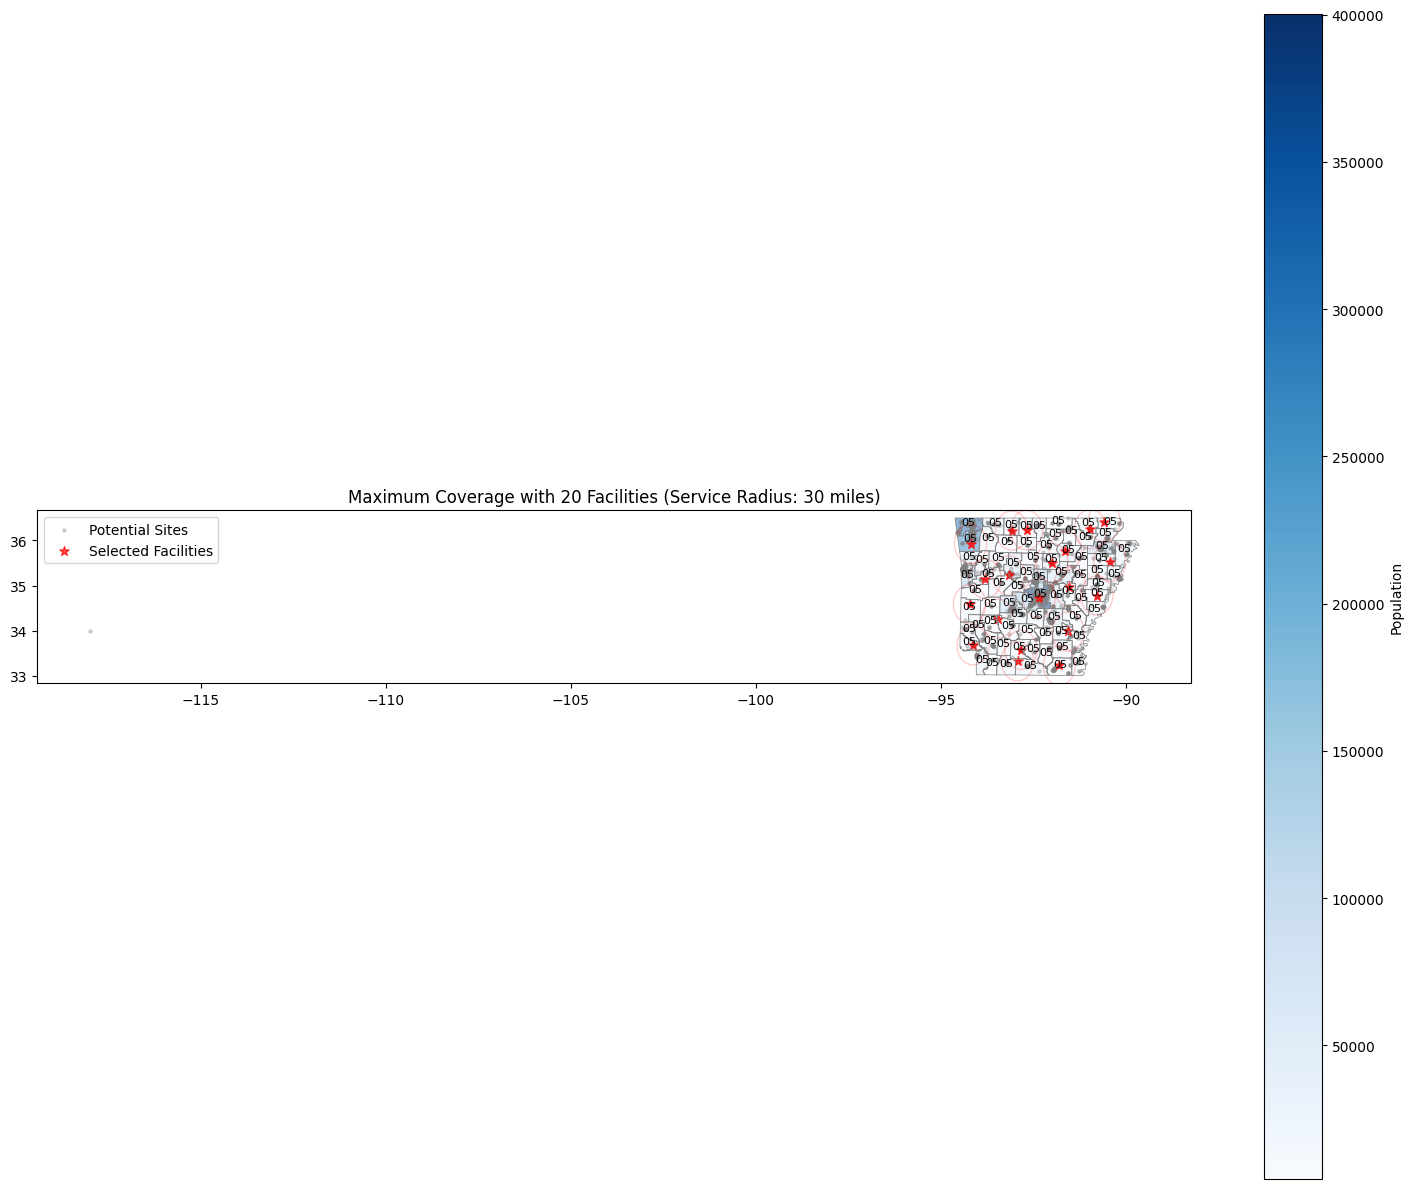

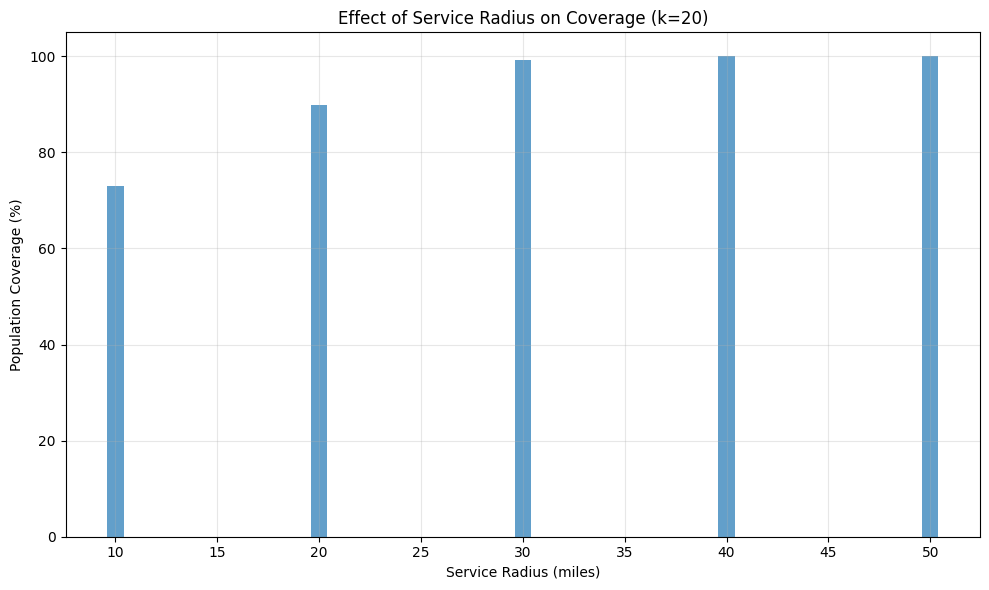

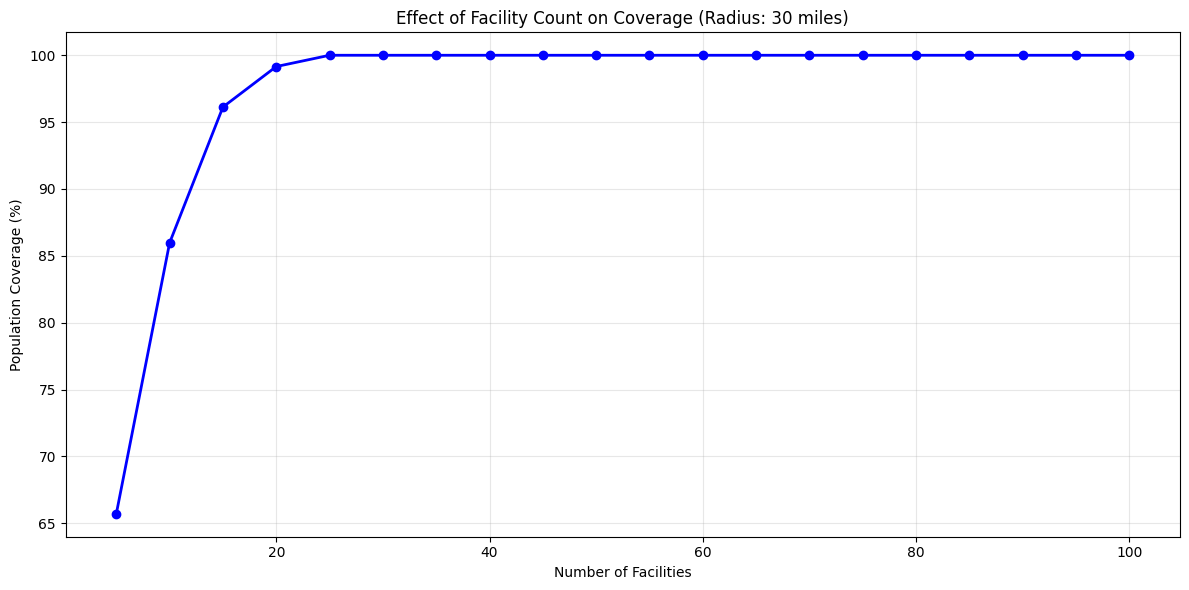

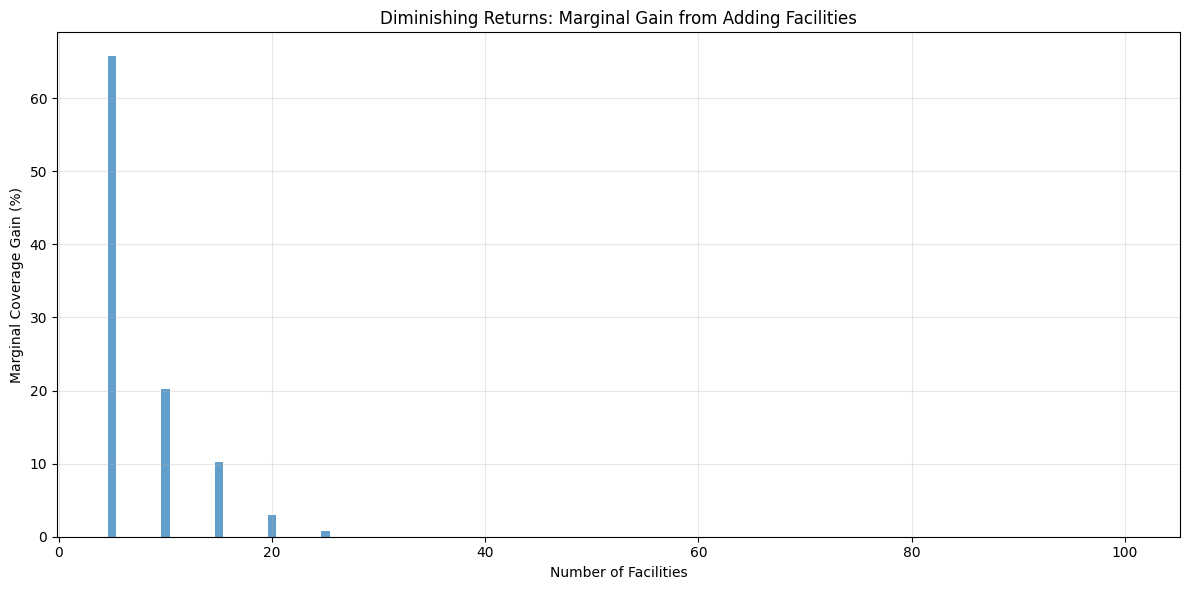

In [6]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point
import os

# Function to calculate Haversine distance (in miles) between two lat/lon points
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 3956  # Radius of earth in miles
    return c * r

# Step 1: Load the county shapefile
def load_county_shapefile(shapefile_path):
    """
    Load county shapefile and add population data
    
    Args:
        shapefile_path: Path to the county shapefile
        
    Returns:
        GeoDataFrame with county shapes and population data
    """
    # Load the shapefile
    counties = gpd.read_file(shapefile_path)
    
    # Add population data (this would ideally be in the shapefile)
    # If it's not in the shapefile, we'll add it manually
    # Arkansas counties population data (2023 estimates)
    county_pop = {
        "Pulaski": 400009,
        "Benton": 311013,
        "Washington": 261549,
        "Faulkner": 129951,
        "Saline": 129574,
        "Sebastian": 129098,
        "Craighead": 113993,
        "Garland": 99784,
        "White": 78452,
        "Lonoke": 75944,
        "Pope": 64593,
        "Jefferson": 63661,
        "Crawford": 61891,
        "Crittenden": 47139,
        "Greene": 46743,
        "Baxter": 42875,
        "Miller": 42415,
        "Mississippi": 38663,
        "Boone": 38530,
        "Independence": 38320,
        "Union": 37397,
        "Hot Spring": 33258,
        "Carroll": 28814,
        "Johnson": 26129,
        "Cleburne": 25445,
        "Poinsett": 22397,
        "Columbia": 22150,
        "St. Francis": 22101,
        "Ouachita": 21793,
        "Logan": 21400,
        "Clark": 21274,
        "Conway": 21077,
        "Yell": 20044,
        "Hempstead": 19343,
        "Polk": 19436,
        "Randolph": 18907,
        "Grant": 18383,
        "Ashley": 18262,
        "Sharp": 17968,
        "Madison": 17775,
        "Marion": 17514,
        "Franklin": 17468,
        "Drew": 16945,
        "Jackson": 16784,
        "Cross": 16420,
        "Lawrence": 16318,
        "Arkansas": 16307,
        "Van Buren": 16142,
        "Sevier": 15632,
        "Phillips": 14961,
        "Clay": 14201,
        "Izard": 14169,
        "Stone": 12671,
        "Howard": 12533,
        "Fulton": 12421,
        "Lincoln": 12898,
        "Little River": 11805,
        "Pike": 10208,
        "Perry": 10184,
        "Bradley": 10104,
        "Desha": 10479,
        "Chicot": 9538,
        "Scott": 9851,
        "Montgomery": 8620,
        "Lee": 8201,
        "Nevada": 8120,
        "Prairie": 8036,
        "Searcy": 7806,
        "Cleveland": 7378,
        "Newton": 7071,
        "Monroe": 6512,
        "Dallas": 6185,
        "Lafayette": 6095,
        "Woodruff": 5964,
        "Calhoun": 4641
    }
    
    # Identify the county name column in the shapefile
    # This might be 'NAME', 'COUNTY', 'COUNTYNAME', etc.
    county_name_col = None
    potential_cols = ['NAME', 'COUNTY', 'COUNTYNAME', 'COUNTY_NAME', 'NAME10', 'NAMELSAD']
    for col in potential_cols:
        if col in counties.columns:
            county_name_col = col
            break
    
    if county_name_col is None:
        print(f"Warning: Could not identify county name column. Available columns are: {counties.columns.tolist()}")
        # Use the first column as a fallback
        county_name_col = counties.columns[0]
        print(f"Using '{county_name_col}' as the county name column")
    
    # Add population data
    counties['population'] = counties[county_name_col].apply(
        lambda x: county_pop.get(x, 
                                # Try to handle variations in county names
                                county_pop.get(x.replace(' County', ''), 
                                            # Default population if not found
                                            20000))
    )
    
    # Calculate centroids for distance calculations
    counties['centroid_lon'] = counties.geometry.centroid.x
    counties['centroid_lat'] = counties.geometry.centroid.y
    
    return counties

# Step 2: Load potential sites
def load_potential_sites(csv_path):
    """
    Load potential site locations from CSV
    
    Args:
        csv_path: Path to CSV file with site data
        
    Returns:
        DataFrame with site information including coordinates
    """
    sites = pd.read_csv(csv_path)
    
    # Ensure latitude and longitude columns exist
    if 'latitude' not in sites.columns or 'longitude' not in sites.columns:
        raise ValueError("CSV must contain 'latitude' and 'longitude' columns")
    
    # Drop rows with missing coordinates
    sites = sites.dropna(subset=['latitude', 'longitude'])
    
    # Convert to GeoDataFrame
    geometry = [Point(xy) for xy in zip(sites['longitude'], sites['latitude'])]
    sites_gdf = gpd.GeoDataFrame(sites, geometry=geometry, crs="EPSG:4326")
    
    return sites_gdf

# Step 3: Calculate coverage matrix using spatial operations
def calculate_coverage_matrix(sites_gdf, counties_gdf, service_radius):
    """
    Calculate which sites cover which counties using spatial operations
    
    Args:
        sites_gdf: GeoDataFrame with site locations
        counties_gdf: GeoDataFrame with county boundaries
        service_radius: Service radius in miles
        
    Returns:
        Binary matrix where coverage_matrix[i, j] = 1 if site i covers county j
    """
    n_sites = len(sites_gdf)
    n_counties = len(counties_gdf)
    coverage_matrix = np.zeros((n_sites, n_counties), dtype=int)
    
    # Create a function to check if a site covers a county
    def covers_county(site_point, county_geom, county_centroid_lon, county_centroid_lat, radius):
        # Calculate distance to county centroid
        site_lon, site_lat = site_point.x, site_point.y
        distance = haversine(site_lon, site_lat, county_centroid_lon, county_centroid_lat)
        
        # If distance is less than radius, consider it covered
        if distance <= radius:
            return True
        
        # For large counties, we might also want to check if the site is within the county
        if site_point.within(county_geom):
            return True
            
        # Additional check: if the service radius buffer intersects with the county
        # This is more computationally expensive, so we do it last
        # To do this properly, we'd need to reproject to a projected CRS and create a buffer
        # For simplicity, we'll just use the centroid distance check for now
        
        return False
    
    # Calculate coverage
    for i, site in sites_gdf.iterrows():
        site_point = site.geometry
        for j, county in counties_gdf.iterrows():
            if covers_county(site_point, county.geometry, 
                            county['centroid_lon'], county['centroid_lat'], 
                            service_radius):
                coverage_matrix[i, j] = 1
    
    return coverage_matrix

# Step 4: Implement greedy algorithm for maximum coverage
def greedy_max_coverage(sites_gdf, counties_gdf, coverage_matrix, k):
    """
    Greedy algorithm for maximum coverage
    
    Args:
        sites_gdf: GeoDataFrame with site data
        counties_gdf: GeoDataFrame with county data
        coverage_matrix: Binary matrix indicating which sites cover which counties
        k: Number of sites to select
        
    Returns:
        Dictionary with selected sites and coverage metrics
    """
    total_population = counties_gdf['population'].sum()
    population_array = counties_gdf['population'].values
    
    # Track covered counties and selected sites
    covered = np.zeros(len(counties_gdf), dtype=bool)
    selected_sites = []
    covered_by_site = {}  # Track which counties each site covers
    
    for _ in range(k):
        best_site = -1
        max_new_coverage = 0
        best_new_covered = []
        
        # For each candidate site
        for i in range(len(sites_gdf)):
            if i in selected_sites:
                continue
                
            # Find which uncovered counties this site would cover
            new_covered = []
            new_coverage = 0
            
            for j in range(len(counties_gdf)):
                if not covered[j] and coverage_matrix[i, j] == 1:
                    new_coverage += population_array[j]
                    new_covered.append(j)
            
            # Update best site if this one covers more population
            if new_coverage > max_new_coverage:
                max_new_coverage = new_coverage
                best_site = i
                best_new_covered = new_covered
        
        # If we can't cover any more population, break
        if best_site == -1 or max_new_coverage == 0:
            break
            
        # Add the best site to our selection
        selected_sites.append(best_site)
        covered_by_site[best_site] = best_new_covered
        
        # Update covered counties
        for j in best_new_covered:
            covered[j] = True
    
    # Calculate total covered population
    covered_population = 0
    covered_county_indices = [j for j in range(len(counties_gdf)) if covered[j]]
    
    for j in range(len(counties_gdf)):
        if covered[j]:
            covered_population += population_array[j]
    
    coverage_percentage = (covered_population / total_population) * 100
    
    return {
        'selected_sites': sites_gdf.iloc[selected_sites].copy(),
        'covered_counties': counties_gdf.iloc[covered_county_indices].copy(),
        'covered_population': covered_population,
        'coverage_percentage': coverage_percentage,
        'covered_by_site': covered_by_site  # For visualization purposes
    }

# Step 5: Visualize results
def plot_coverage_map(sites_gdf, counties_gdf, selected_sites, covered_counties, covered_by_site, service_radius):
    """
    Plot a map showing counties, potential sites, and selected sites with coverage
    
    Args:
        sites_gdf: GeoDataFrame with all potential sites
        counties_gdf: GeoDataFrame with county shapes
        selected_sites: GeoDataFrame with selected sites
        covered_counties: GeoDataFrame with covered counties
        covered_by_site: Dictionary mapping site indices to covered county indices
        service_radius: Service radius in miles
    """
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Plot county boundaries
    counties_gdf.boundary.plot(ax=ax, linewidth=0.5, color='gray')
    
    # Plot covered counties with color based on population
    covered_counties.plot(ax=ax, column='population', cmap='Blues', alpha=0.5, 
                         legend=True, legend_kwds={'label': 'Population'})
    
    # Plot all potential sites
    sites_gdf.plot(ax=ax, color='gray', markersize=5, alpha=0.3, label='Potential Sites')
    
    # Plot selected sites
    selected_sites.plot(ax=ax, color='red', markersize=50, marker='*', alpha=0.7, label='Selected Facilities')
    
    # Draw service radius circles for each selected site
    # To do this properly, we'd need to reproject to a projected CRS
    # For visualization purposes, we'll use a simplified approach
    # Note: This is an approximation and won't be geographically accurate
    for _, site in selected_sites.iterrows():
        circle = plt.Circle((site.geometry.x, site.geometry.y), 
                           service_radius / 69.0,  # Convert miles to approximate degrees
                           color='red', fill=False, alpha=0.2)
        ax.add_patch(circle)
    
    # Add county labels for context
    for idx, county in counties_gdf.iterrows():
        plt.annotate(text=county[counties_gdf.columns[0]], xy=(county.centroid_lon, county.centroid_lat),
                    fontsize=8, ha='center')
    
    # Add title and legend
    plt.title(f'Maximum Coverage with {len(selected_sites)} Facilities (Service Radius: {service_radius} miles)')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    return fig, ax

# Step 6: Analyze service radius and facility count impacts
def compare_service_radii(sites_gdf, counties_gdf, k=20, radii=[10, 20, 30, 40, 50]):
    """
    Compare coverage achieved with different service radii
    
    Args:
        sites_gdf: GeoDataFrame with site data
        counties_gdf: GeoDataFrame with county data
        k: Number of facilities
        radii: List of service radii to test
        
    Returns:
        DataFrame with comparison results
    """
    results = {}
    
    for radius in radii:
        print(f"Calculating coverage for radius {radius} miles...")
        coverage_matrix = calculate_coverage_matrix(sites_gdf, counties_gdf, radius)
        result = greedy_max_coverage(sites_gdf, counties_gdf, coverage_matrix, k)
        
        results[radius] = {
            'radius': radius,
            'population_covered': result['covered_population'],
            'coverage_percentage': result['coverage_percentage'],
            'counties_covered': len(result['covered_counties'])
        }
    
    return pd.DataFrame(results).T

def evaluate_facility_count(sites_gdf, counties_gdf, coverage_matrix, max_k=100, step=5):
    """
    Evaluate how the number of facilities affects coverage
    
    Args:
        sites_gdf: GeoDataFrame with site data
        counties_gdf: GeoDataFrame with county data
        coverage_matrix: Coverage matrix for a specific service radius
        max_k: Maximum number of facilities to consider
        step: Step size for facility count
        
    Returns:
        DataFrame with results for different facility counts
    """
    results = {}
    
    for k in range(step, min(max_k + 1, len(sites_gdf) + 1), step):
        print(f"Evaluating {k} facilities...")
        result = greedy_max_coverage(sites_gdf, counties_gdf, coverage_matrix, k)
        
        results[k] = {
            'facilities': k,
            'population_covered': result['covered_population'],
            'coverage_percentage': result['coverage_percentage'],
            'counties_covered': len(result['covered_counties'])
        }
    
    results_df = pd.DataFrame(results).T
    
    # Add marginal gain analysis
    results_df['marginal_gain'] = results_df['coverage_percentage'].diff()
    results_df.loc[results_df.index[0], 'marginal_gain'] = results_df.loc[results_df.index[0], 'coverage_percentage']
    results_df['efficiency'] = results_df['marginal_gain'] / step  # Gain per facility step
    
    return results_df

# Step 7: Main function to run the analysis
def run_coverage_analysis(shapefile_path, sites_csv_path, service_radius=30, k=20, output_dir='output'):
    """
    Run the entire coverage analysis pipeline
    
    Args:
        shapefile_path: Path to county shapefile
        sites_csv_path: Path to potential sites CSV
        service_radius: Service radius in miles
        k: Number of facilities to select
        output_dir: Directory to save outputs
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    print("Loading county shapefile...")
    counties_gdf = load_county_shapefile(shapefile_path)
    
    print("Loading potential sites...")
    sites_gdf = load_potential_sites(sites_csv_path)
    
    print(f"Calculating coverage matrix (radius: {service_radius} miles)...")
    coverage_matrix = calculate_coverage_matrix(sites_gdf, counties_gdf, service_radius)
    
    print(f"Running greedy maximum coverage algorithm (k={k})...")
    result = greedy_max_coverage(sites_gdf, counties_gdf, coverage_matrix, k)
    
    print("Generating coverage visualization...")
    fig, ax = plot_coverage_map(
        sites_gdf, 
        counties_gdf, 
        result['selected_sites'], 
        result['covered_counties'], 
        result['covered_by_site'], 
        service_radius
    )
    fig.savefig(os.path.join(output_dir, f'coverage_map_k{k}_r{service_radius}.png'), dpi=300, bbox_inches='tight')
    
    # Save selected sites to CSV
    result['selected_sites'].to_csv(os.path.join(output_dir, f'selected_sites_k{k}_r{service_radius}.csv'), index=False)
    
    # Compare different service radii
    print("Comparing different service radii...")
    radius_comparison = compare_service_radii(sites_gdf, counties_gdf)
    radius_comparison.to_csv(os.path.join(output_dir, 'radius_comparison.csv'))
    
    # Plot service radius comparison
    plt.figure(figsize=(10, 6))
    plt.bar(radius_comparison.index, radius_comparison['coverage_percentage'], alpha=0.7)
    plt.xlabel('Service Radius (miles)')
    plt.ylabel('Population Coverage (%)')
    plt.title(f'Effect of Service Radius on Coverage (k={k})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'radius_comparison.png'), dpi=300)
    
    # Evaluate facility count impact
    print("Evaluating facility count impact...")
    facility_analysis = evaluate_facility_count(sites_gdf, counties_gdf, coverage_matrix)
    facility_analysis.to_csv(os.path.join(output_dir, f'facility_analysis_r{service_radius}.csv'))
    
    # Plot facility count analysis
    plt.figure(figsize=(12, 6))
    plt.plot(facility_analysis.index, facility_analysis['coverage_percentage'], 'b-o', linewidth=2)
    plt.xlabel('Number of Facilities')
    plt.ylabel('Population Coverage (%)')
    plt.title(f'Effect of Facility Count on Coverage (Radius: {service_radius} miles)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'facility_count_analysis.png'), dpi=300)
    
    # Plot marginal returns
    plt.figure(figsize=(12, 6))
    plt.bar(facility_analysis.index, facility_analysis['marginal_gain'], alpha=0.7)
    plt.xlabel('Number of Facilities')
    plt.ylabel('Marginal Coverage Gain (%)')
    plt.title('Diminishing Returns: Marginal Gain from Adding Facilities')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'marginal_returns.png'), dpi=300)
    
    # Find optimal facility count based on efficiency threshold
    efficiency_threshold = 0.2  # Minimum 0.2% gain per facility step
    optimal_k = facility_analysis[facility_analysis['efficiency'] >= efficiency_threshold].index.max()
    
    print("\n=== MAXIMUM COVERAGE OPTIMIZATION RESULTS ===")
    print(f"Total potential sites: {len(sites_gdf)}")
    print(f"Total counties: {len(counties_gdf)}")
    print(f"Service radius: {service_radius} miles")
    print(f"\nRecommended solution (k={k}):")
    print(f"Population covered: {result['covered_population']:,.0f} ({result['coverage_percentage']:.2f}%)")
    print(f"Counties covered: {len(result['covered_counties'])} out of {len(counties_gdf)}")
    
    print(f"\nOptimal facility count (efficiency threshold: {efficiency_threshold}% gain per facility):")
    print(f"Optimal k: {optimal_k}")
    print(f"Coverage: {facility_analysis.loc[optimal_k, 'coverage_percentage']:.2f}%")
    
    # Create summary report
    with open(os.path.join(output_dir, 'summary_report.txt'), 'w') as f:
        f.write("=== MAXIMUM COVERAGE OPTIMIZATION SUMMARY ===\n\n")
        f.write(f"Analysis date: {pd.Timestamp.now().strftime('%Y-%m-%d')}\n")
        f.write(f"County shapefile: {shapefile_path}\n")
        f.write(f"Potential sites data: {sites_csv_path}\n\n")
        
        f.write(f"Total potential sites: {len(sites_gdf)}\n")
        f.write(f"Total counties: {len(counties_gdf)}\n")
        f.write(f"Service radius: {service_radius} miles\n\n")
        
        f.write(f"Recommended solution (k={k}):\n")
        f.write(f"Population covered: {result['covered_population']:,.0f} ({result['coverage_percentage']:.2f}%)\n")
        f.write(f"Counties covered: {len(result['covered_counties'])} out of {len(counties_gdf)}\n\n")
        
        f.write(f"Optimal facility count (efficiency threshold: {efficiency_threshold}% gain per facility):\n")
        f.write(f"Optimal k: {optimal_k}\n")
        f.write(f"Coverage: {facility_analysis.loc[optimal_k, 'coverage_percentage']:.2f}%\n\n")
        
        f.write("=== SELECTED SITES ===\n\n")
        for i, (_, site) in enumerate(result['selected_sites'].iterrows(), 1):
            site_info = f"{i}. "
            if 'Name' in site:
                site_info += f"{site['Name']} "
            if 'City' in site and 'County' in site:
                site_info += f"({site['City']}, {site['County']}) "
            site_info += f"- ({site.geometry.x:.6f}, {site.geometry.y:.6f})"
            f.write(site_info + "\n")
    
    print(f"\nAll results saved to {output_dir} directory")
    return result

# Example usage
if __name__ == "__main__":
    # Set paths to your data files
    shapefile_path = "////wsl.localhost/Ubuntu/home/amc086/DASC1104redo/python_scripts/Exam2/Data/ACS_2019_5YR_COUNTY_AR.shp"
    sites_csv_path = "//wsl.localhost/Ubuntu/home/amc086/DASC1104redo/python_scripts/final_merged_geocoded_addresses.csv"
    
    # Run the analysis
    run_coverage_analysis(shapefile_path, sites_csv_path)